# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

random.seed(42)
np.random.seed(42)

# Load and Process Data

In [2]:
# Load MovieLens dataset
data_path = 'ml-100k/u.data'
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(data_path, sep='\t', names=column_names)

In [3]:
# Preprocess the dataset
user_ids = data['user_id'].unique()
item_ids = data['item_id'].unique()
uid2idx = {uid: idx for idx, uid in enumerate(user_ids)}
iid2idx = {iid: idx for idx, iid in enumerate(item_ids)}
data['user_id'] = data['user_id'].map(uid2idx)
data['item_id'] = data['item_id'].map(iid2idx)

In [4]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Visualize Data

In [5]:
data.head()

,user_id,item_id,rating,timestamp
0,0,0,3,881250949
1,1,1,3,891717742
2,2,2,1,878887116
3,3,3,2,880606923
4,4,4,1,886397596


In [6]:
print('Number of users: ', len(user_ids))
print('Number of items: ', len(item_ids))
print('Number of interactions: ', len(data))
print('Average rating: ', data['rating'].mean())
print('Start Date: ', pd.to_datetime(data['timestamp'].min(), unit='s'))
print('End Date: ', pd.to_datetime(data['timestamp'].max(), unit='s'))

Number of users:  943
Number of items:  1682
Number of interactions:  100000
Average rating:  3.52986
Start Date:  1997-09-20 03:05:10
End Date:  1998-04-22 23:10:38


# Create Movie Lens Dataset

In [7]:
class MovieLensDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        return row['user_id'], row['item_id'], row['rating']

# Create NextItNet Model

This model isn't NextItNet as it doesn't take sequential data into account. It follows a very similar structure and is entirely based on NextItNet, but doesn't account for the sequence of the data

In [8]:
class NextItNet(nn.Module):
    def __init__(self, num_users, num_items, emb_dim, dilation_rates, dropout_rate=0.5):
        super(NextItNet, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        self.blocks = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        
        for rate in dilation_rates:
            self.blocks.append(
                nn.Sequential(
                    nn.Conv1d(emb_dim, emb_dim, kernel_size=3, padding=rate, dilation=rate),
                    nn.ReLU(),
                    nn.BatchNorm1d(emb_dim),
                    nn.Dropout(dropout_rate),
                )
            )
        self.fc = nn.Linear(emb_dim, 1)

    def forward(self, user_ids, item_ids): # Shapes added for clarity in comments
        user_emb = self.user_emb(user_ids)
        item_emb = self.item_emb(item_ids)
        # (batch, emb_dim)
        x = (user_emb * item_emb).unsqueeze(2)
        # (batch, emb_dim, 1)
        x = self.dropout(x)
        for block in self.blocks:
            x = block(x)
        # (batch, emb_dim, 1)
        x = x.squeeze(2)
        # (batch, emb_dim)
        x = self.fc(x)
        # (batch)
        return x.squeeze(1)

# Initiate Model

In [9]:
# Hyperparameters
emb_dim = 32
dilation_rates = [1, 2, 4]
num_epochs = 50
batch_size = 128
learning_rate = 0.001
weight_decay = 1e-4

In [10]:
# Create the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NextItNet(len(user_ids), len(item_ids), emb_dim, dilation_rates).to(device)

In [11]:
# Prepare the data
train_dataset = MovieLensDataset(train_data)
test_dataset = MovieLensDataset(test_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
# Set up the loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [13]:
# Set up the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Early stopping settings
early_stopping_patience = 10
epochs_without_improvement = 0
best_test_loss = float('inf')

# Train Model

In [59]:
# Training loop
train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs), desc='Epoch'):
    model.train()
    train_loss = 0
    for user_ids, item_ids, ratings in train_loader:
        user_ids = user_ids.to(device, dtype=torch.long)
        item_ids = item_ids.to(device, dtype=torch.long)
        ratings = ratings.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(user_ids, item_ids)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}')

    # Evaluation loop
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for user_ids, item_ids, ratings in test_loader:
            user_ids = user_ids.to(device, dtype=torch.long)
            item_ids = item_ids.to(device, dtype=torch.long)
            ratings = ratings.to(device, dtype=torch.float)

            outputs = model(user_ids, item_ids)
            loss = criterion(outputs, ratings)

            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss}')

    # Update the scheduler and check for early stopping
    scheduler.step(test_loss)

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        print(f'Early stopping after {early_stopping_patience} epochs without improvement')
        break

torch.save(model.state_dict(), 'nextitnet.pth')


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Training Loss: 5.54312151966095


Epoch:   2%|▏         | 1/50 [00:20<16:51, 20.64s/it]

Epoch 1/50, Test Loss: 1.3159393899759668
Epoch 2/50, Training Loss: 1.9027035402297974


Epoch:   4%|▍         | 2/50 [00:40<16:18, 20.39s/it]

Epoch 2/50, Test Loss: 1.2928687675743347
Epoch 3/50, Training Loss: 1.6601207273483276


Epoch:   6%|▌         | 3/50 [01:01<15:56, 20.36s/it]

Epoch 3/50, Test Loss: 1.279566830890194
Epoch 4/50, Training Loss: 1.561107444381714


Epoch:   8%|▊         | 4/50 [01:21<15:37, 20.37s/it]

Epoch 4/50, Test Loss: 1.276670395948325
Epoch 5/50, Training Loss: 1.5133821387290955


Epoch:  10%|█         | 5/50 [01:42<15:29, 20.65s/it]

Epoch 5/50, Test Loss: 1.2690292152629536
Epoch 6/50, Training Loss: 1.4830015405654908


Epoch:  12%|█▏        | 6/50 [02:03<15:10, 20.68s/it]

Epoch 6/50, Test Loss: 1.273353889869277
Epoch 7/50, Training Loss: 1.4576039768218993


Epoch:  14%|█▍        | 7/50 [02:24<14:53, 20.78s/it]

Epoch 7/50, Test Loss: 1.291919000589164
Epoch 8/50, Training Loss: 1.411486066532135


Epoch:  16%|█▌        | 8/50 [02:44<14:25, 20.62s/it]

Epoch 8/50, Test Loss: 1.2618294726511476
Epoch 9/50, Training Loss: 1.3758090873718263


Epoch:  18%|█▊        | 9/50 [03:04<14:00, 20.49s/it]

Epoch 9/50, Test Loss: 1.247157166717918
Epoch 10/50, Training Loss: 1.3298490007400512


Epoch:  20%|██        | 10/50 [03:25<13:36, 20.42s/it]

Epoch 10/50, Test Loss: 1.221982790026695
Epoch 11/50, Training Loss: 1.2861334128379822


Epoch:  22%|██▏       | 11/50 [03:45<13:15, 20.40s/it]

Epoch 11/50, Test Loss: 1.1929096226479596
Epoch 12/50, Training Loss: 1.235790962791443


Epoch:  24%|██▍       | 12/50 [04:06<12:58, 20.48s/it]

Epoch 12/50, Test Loss: 1.155794243524029
Epoch 13/50, Training Loss: 1.1912790013313292


Epoch:  26%|██▌       | 13/50 [04:26<12:38, 20.49s/it]

Epoch 13/50, Test Loss: 1.1206092344727485
Epoch 14/50, Training Loss: 1.147081339073181


Epoch:  28%|██▊       | 14/50 [04:46<12:14, 20.40s/it]

Epoch 14/50, Test Loss: 1.099704817981477
Epoch 15/50, Training Loss: 1.112819491481781


Epoch:  30%|███       | 15/50 [05:07<11:56, 20.46s/it]

Epoch 15/50, Test Loss: 1.0655572030954301
Epoch 16/50, Training Loss: 1.0820539039611816


Epoch:  32%|███▏      | 16/50 [05:27<11:34, 20.42s/it]

Epoch 16/50, Test Loss: 1.0549214436749743
Epoch 17/50, Training Loss: 1.0560373313903808


Epoch:  34%|███▍      | 17/50 [05:48<11:18, 20.55s/it]

Epoch 17/50, Test Loss: 1.0279396237081784
Epoch 18/50, Training Loss: 1.0374763840675354


Epoch:  36%|███▌      | 18/50 [06:09<10:58, 20.57s/it]

Epoch 18/50, Test Loss: 1.0122224601211063
Epoch 19/50, Training Loss: 1.0108069392204284


Epoch:  38%|███▊      | 19/50 [06:30<10:39, 20.64s/it]

Epoch 19/50, Test Loss: 0.9969836192525876
Epoch 20/50, Training Loss: 0.9895143046379089


Epoch:  40%|████      | 20/50 [06:50<10:19, 20.65s/it]

Epoch 20/50, Test Loss: 0.9887528958593964
Epoch 21/50, Training Loss: 0.9721973362922669


Epoch:  42%|████▏     | 21/50 [07:11<09:58, 20.63s/it]

Epoch 21/50, Test Loss: 0.9907363732908941
Epoch 22/50, Training Loss: 0.9537272249221802


Epoch:  44%|████▍     | 22/50 [07:31<09:36, 20.61s/it]

Epoch 22/50, Test Loss: 0.98615290063202
Epoch 23/50, Training Loss: 0.9317643490791321


Epoch:  46%|████▌     | 23/50 [07:52<09:14, 20.53s/it]

Epoch 23/50, Test Loss: 0.971898870862973
Epoch 24/50, Training Loss: 0.9133451922416687


Epoch:  48%|████▊     | 24/50 [08:12<08:52, 20.46s/it]

Epoch 24/50, Test Loss: 0.9699461209546228
Epoch 25/50, Training Loss: 0.9030046067237854


Epoch:  50%|█████     | 25/50 [08:32<08:29, 20.39s/it]

Epoch 25/50, Test Loss: 0.9693510972770156
Epoch 26/50, Training Loss: 0.8835937991142273


Epoch:  52%|█████▏    | 26/50 [08:53<08:11, 20.49s/it]

Epoch 26/50, Test Loss: 0.9576759326989484
Epoch 27/50, Training Loss: 0.8701251630783081


Epoch:  54%|█████▍    | 27/50 [09:13<07:50, 20.46s/it]

Epoch 27/50, Test Loss: 0.9650922246799347
Epoch 28/50, Training Loss: 0.8580639317512512


Epoch:  56%|█████▌    | 28/50 [09:35<07:35, 20.72s/it]

Epoch 28/50, Test Loss: 0.9584647880238333
Epoch 29/50, Training Loss: 0.8458654092788697


Epoch:  58%|█████▊    | 29/50 [09:55<07:13, 20.63s/it]

Epoch 29/50, Test Loss: 0.9694307260452562
Epoch 30/50, Training Loss: 0.8390447508811951


Epoch:  60%|██████    | 30/50 [10:16<06:52, 20.60s/it]

Epoch 30/50, Test Loss: 0.9460842989052937
Epoch 31/50, Training Loss: 0.8294632146835327


Epoch:  62%|██████▏   | 31/50 [10:36<06:29, 20.52s/it]

Epoch 31/50, Test Loss: 0.9465137264531129
Epoch 32/50, Training Loss: 0.8176210125923157


Epoch:  64%|██████▍   | 32/50 [10:57<06:12, 20.67s/it]

Epoch 32/50, Test Loss: 0.955308278654791
Epoch 33/50, Training Loss: 0.8167040771484375


Epoch:  66%|██████▌   | 33/50 [11:18<05:53, 20.78s/it]

Epoch 33/50, Test Loss: 0.9444488381883901
Epoch 34/50, Training Loss: 0.8067886756896973


Epoch:  68%|██████▊   | 34/50 [11:39<05:32, 20.80s/it]

Epoch 34/50, Test Loss: 0.9434722278528153
Epoch 35/50, Training Loss: 0.8057053010940551


Epoch:  70%|███████   | 35/50 [11:59<05:09, 20.61s/it]

Epoch 35/50, Test Loss: 0.9534301666697119
Epoch 36/50, Training Loss: 0.7940056471824646


Epoch:  72%|███████▏  | 36/50 [12:19<04:47, 20.51s/it]

Epoch 36/50, Test Loss: 0.9494588253604379
Epoch 37/50, Training Loss: 0.7879968217849731


Epoch:  74%|███████▍  | 37/50 [12:40<04:28, 20.65s/it]

Epoch 37/50, Test Loss: 0.9591473113199708
Epoch 38/50, Training Loss: 0.7875300031661987


Epoch:  76%|███████▌  | 38/50 [13:02<04:10, 20.86s/it]

Epoch 38/50, Test Loss: 0.9571581649932133
Epoch 39/50, Training Loss: 0.782989196395874


Epoch:  78%|███████▊  | 39/50 [13:22<03:49, 20.83s/it]

Epoch 39/50, Test Loss: 0.9452814121914518
Epoch 40/50, Training Loss: 0.7788204606056214


Epoch:  80%|████████  | 40/50 [13:44<03:29, 20.95s/it]

Epoch 40/50, Test Loss: 0.9505444803055684
Epoch 00040: reducing learning rate of group 0 to 1.0000e-04.
Epoch 41/50, Training Loss: 0.7652505699157715


Epoch:  82%|████████▏ | 41/50 [14:04<03:06, 20.72s/it]

Epoch 41/50, Test Loss: 0.9509217218988261
Epoch 42/50, Training Loss: 0.7583853444099427


Epoch:  84%|████████▍ | 42/50 [14:27<02:50, 21.37s/it]

Epoch 42/50, Test Loss: 0.9434668831764512
Epoch 43/50, Training Loss: 0.7498998214721679


Epoch:  86%|████████▌ | 43/50 [14:49<02:31, 21.61s/it]

Epoch 43/50, Test Loss: 0.9396136190481247
Epoch 44/50, Training Loss: 0.7542089618682861


Epoch:  88%|████████▊ | 44/50 [15:15<02:16, 22.82s/it]

Epoch 44/50, Test Loss: 0.9396791940282105
Epoch 45/50, Training Loss: 0.7525479866981506


Epoch:  90%|█████████ | 45/50 [15:45<02:06, 25.21s/it]

Epoch 45/50, Test Loss: 0.936878626513633
Epoch 46/50, Training Loss: 0.7500464587211609


Epoch:  92%|█████████▏| 46/50 [16:25<01:58, 29.59s/it]

Epoch 46/50, Test Loss: 0.9282467851213588
Epoch 47/50, Training Loss: 0.7514593077659607


Epoch:  94%|█████████▍| 47/50 [16:45<01:20, 26.76s/it]

Epoch 47/50, Test Loss: 0.9421824239621497
Epoch 48/50, Training Loss: 0.7405369520187378


Epoch:  96%|█████████▌| 48/50 [17:05<00:49, 24.77s/it]

Epoch 48/50, Test Loss: 0.944155909453228
Epoch 49/50, Training Loss: 0.7417316729545593


Epoch:  98%|█████████▊| 49/50 [17:34<00:26, 26.04s/it]

Epoch 49/50, Test Loss: 0.9292626232857917
Epoch 50/50, Training Loss: 0.7454068026542664


Epoch: 100%|██████████| 50/50 [17:55<00:00, 21.50s/it]

Epoch 50/50, Test Loss: 0.9469558171405914


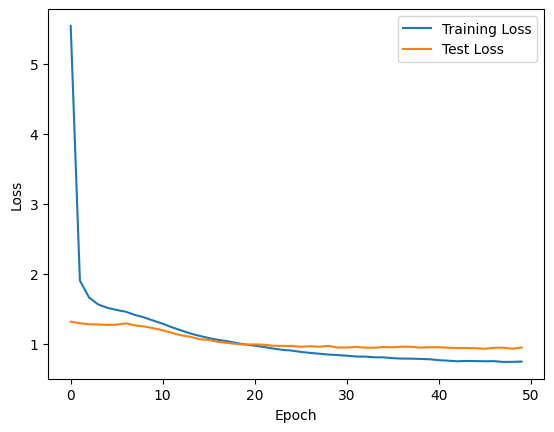

In [60]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
model.load_state_dict(torch.load('nextitnet.pth', map_location=device))

<All keys matched successfully>

# Outcome Visualization

In [15]:
print('Train Dataset Length: ', len(train_dataset))
print('Test Dataset Length: ', len(test_dataset))

Train Dataset Length:  80000
Test Dataset Length:  20000


In [16]:
model.eval()
for _ in range(5):
    user_id, item_id, rating = random.choice(test_dataset)
    user_id = torch.tensor([user_id]).to(device)
    item_id = torch.tensor([item_id]).to(device)
    rating = torch.tensor([rating]).to(device)
    output = model(user_id, item_id)
    print(f'User: {user_id.item()}, Item: {item_id.item()}, Actual Rating: {rating.item()}, Predicted Rating: {output.item()}')

User: 505, Item: 403, Actual Rating: 2, Predicted Rating: 2.6854872703552246
User: 188, Item: 360, Actual Rating: 4, Predicted Rating: 3.0227606296539307
User: 229, Item: 487, Actual Rating: 3, Predicted Rating: 3.6228487491607666
User: 102, Item: 114, Actual Rating: 3, Predicted Rating: 2.313917875289917
User: 153, Item: 311, Actual Rating: 3, Predicted Rating: 3.529111862182617


# Recommender Test

In [17]:
movies = pd.read_csv('ml-100k/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### User Test

In [18]:
# Predict next item for a user
model.eval()

user_id = random.choice(user_ids)
all_item_ids = torch.tensor(item_ids).to(device)
user_ids_ = torch.full((len(item_ids),), user_id).to(device, dtype=torch.long)

outputs = {}
with torch.no_grad():
    user = torch.tensor([user_id]).to(device)
    for item_idx in all_item_ids:
        item = torch.tensor([item_idx-1]).to(device)
        output = model(user, item)
        outputs[item_idx.item()] = output.item()

# Get the top 10 recommendations
top_10 = sorted(outputs, key=outputs.get, reverse=True)[:10]
print(f'Top 10 Recommendations for user {user_id}:')
for item_id in top_10:
    movie = movies.loc[movies['movieId'] == item_id]['title'].values
    if len(movie) == 0: movie = 'Unknown'
    else: movie = movie[0]
    print(f'Movie: {movie}, Item ID: {item_id}, Predicted Rating: {outputs[item_id]}')

Top 10 Recommendations for user 100:
Movie: Usual Suspects, The (1995), Item ID: 50, Predicted Rating: 4.701772689819336
Movie: Babysitter, The (1995), Item ID: 217, Predicted Rating: 4.62786865234375
Movie: Heat (1995), Item ID: 6, Predicted Rating: 4.505310535430908
Movie: Menace II Society (1993), Item ID: 493, Predicted Rating: 4.410915374755859
Movie: Radioland Murders (1994), Item ID: 513, Predicted Rating: 4.388902187347412
Movie: Only You (1994), Item ID: 289, Predicted Rating: 4.3602375984191895
Movie: Safe (1995), Item ID: 190, Predicted Rating: 4.353085994720459
Movie: Amateur (1994), Item ID: 149, Predicted Rating: 4.308145999908447
Movie: Mighty Morphin Power Rangers: The Movie (1995), Item ID: 181, Predicted Rating: 4.271055221557617
Movie: Broken Arrow (1996), Item ID: 95, Predicted Rating: 4.2466230392456055
